In [32]:
!pip install --upgrade autokeras

In [33]:
import autokeras as ak
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn.ensemble import RandomForestClassifier

In [34]:
from google.colab import drive
import os
drive.mount('/gdrive')
file_path = '/gdrive/MyDrive/breast cancer/breast-cancer.csv'

# Read the CSV file
data = pd.read_csv(file_path)
data.head()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [35]:
data = data.drop(columns=['id'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

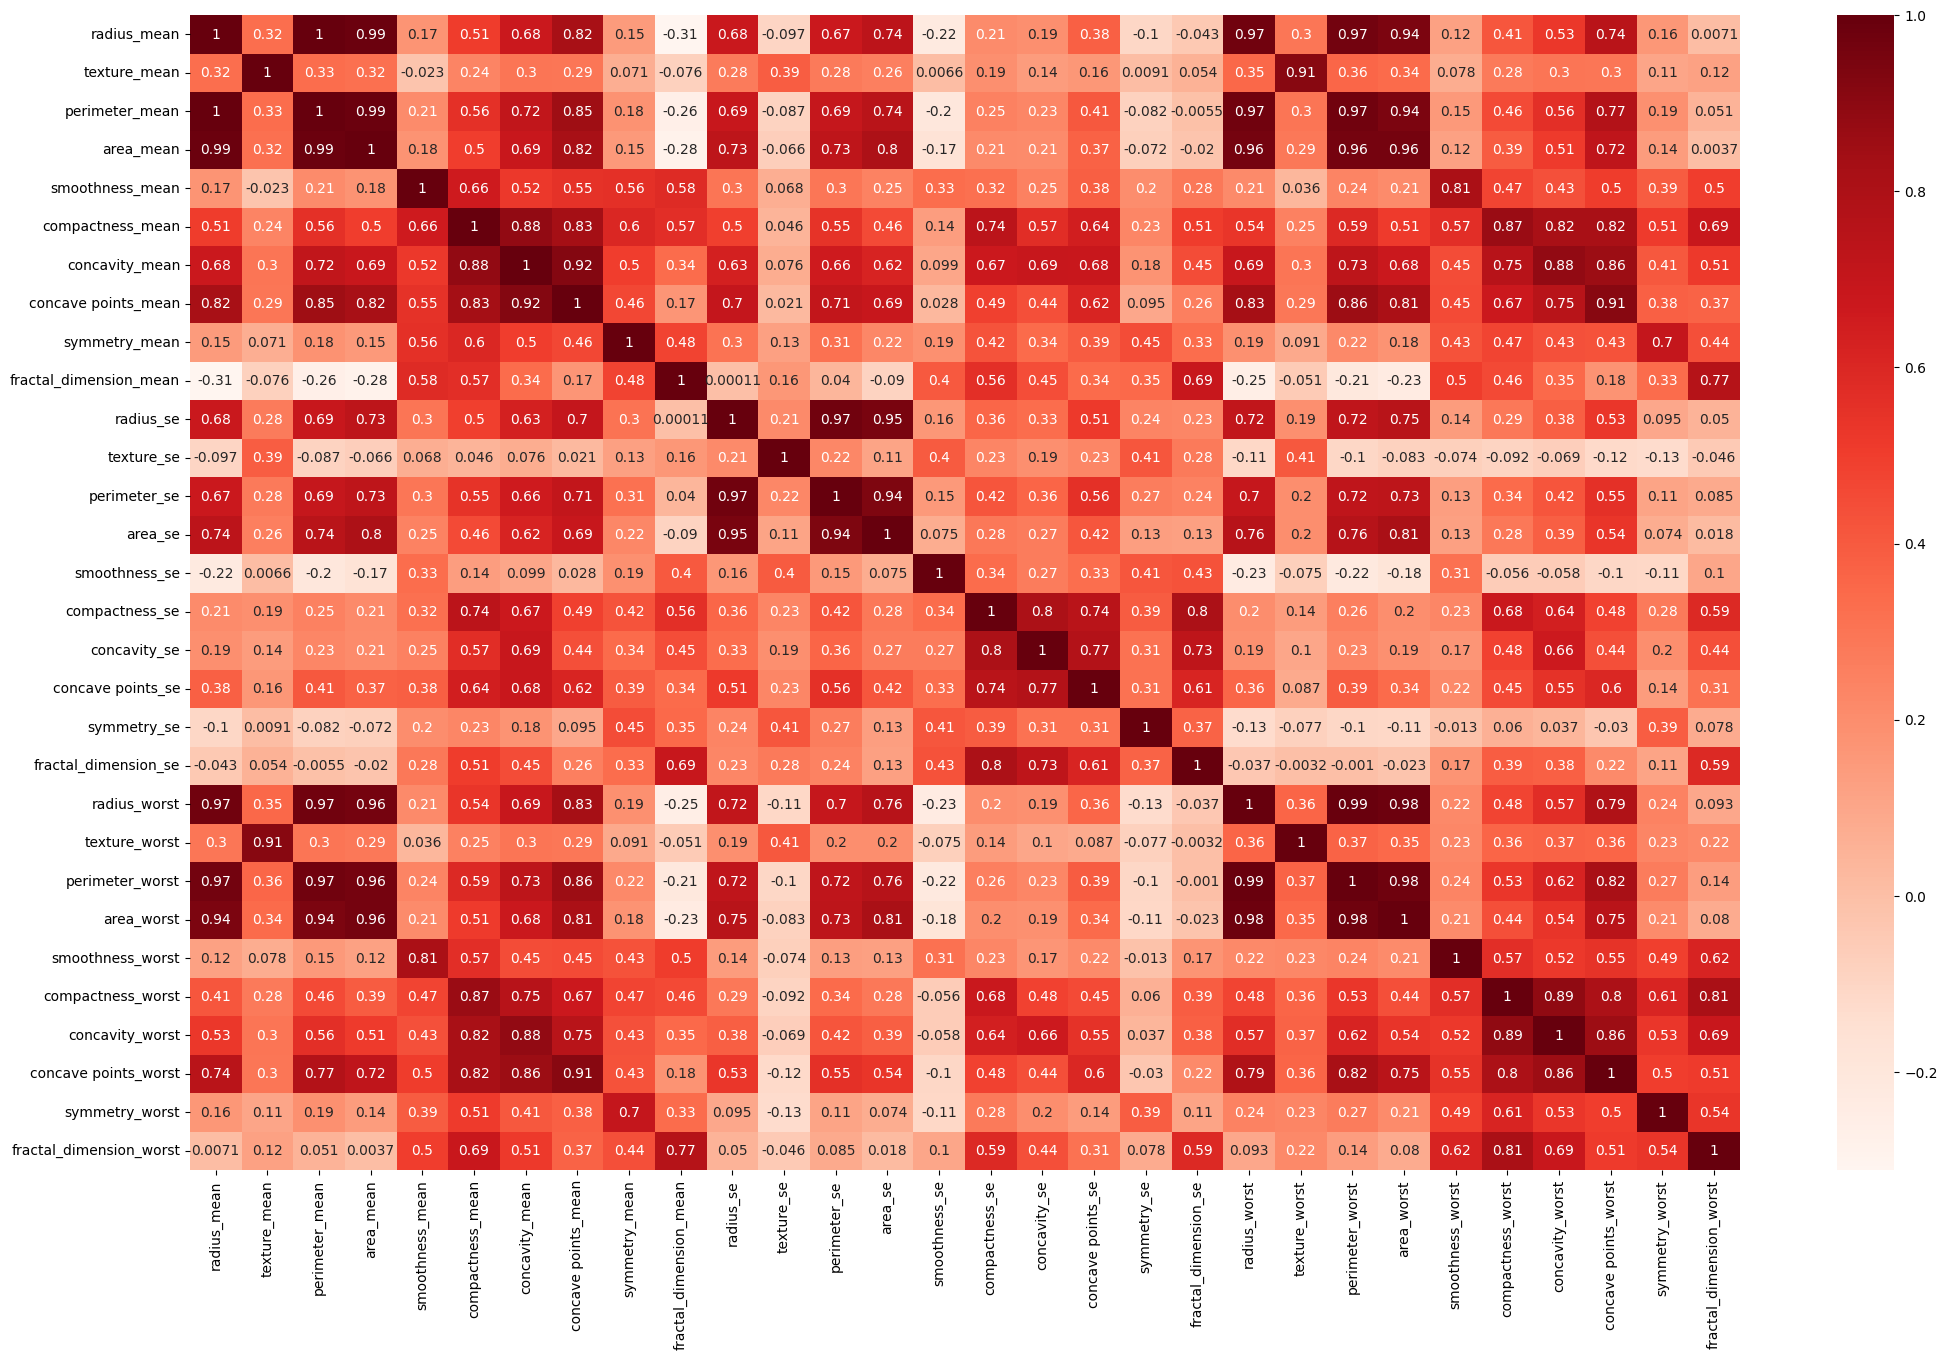

In [36]:
def find_nulls(data: pd.DataFrame) -> pd.DataFrame:
    temp = {'columns':[], 'nulls':[], 'nulls_%':[], 'unique':[]}
    nulls = data.isnull().sum()
    temp['columns'] = nulls.index
    temp['nulls'] = nulls.values
    temp['nulls_%'] = (nulls.values * 100) / data.shape[0]
    temp['unique'] = [data[i].nunique() for i in nulls.index]
    temp = pd.DataFrame(temp)
    return temp.sort_values('nulls')

null_info = find_nulls(data)
null_info.style.background_gradient(cmap='Reds')

plt.figure(figsize=(25, 15))
sns.heatmap(data.drop(columns=['diagnosis']).corr(), annot=True, cmap='Reds')
plt.show()

In [37]:
# Define the columns you want to exclude from ANOVA and feature selection
cols = ['area_mean', 'perimeter_mean', 'area_worst', 'perimeter_worst', 'perimeter_se', 'area_se']


# Perform feature selection based on ANOVA
def anova(data: pd.DataFrame, cols: list, output: str):
    for col in cols:
        SSB, SSW = 0, 0
        mean = data[col].mean()
        for i in data[output].unique():
            temp = data[data[output] == i][col]
            SSB += temp.shape[0] * (mean - temp.mean())**2
            SSW += np.sum((temp - temp.mean())**2)
        db = data[output].nunique() - 1
        dw = data[col].shape[0] - data[output].nunique()
        critical = (SSB / db) / (SSW / dw)
        if critical < f.ppf(0.95, db, dw):
            print("Failed to reject null hypothesis between", col, 'and', output)

anova(data, data.columns.drop(cols).drop('diagnosis'), 'diagnosis')

Failed to reject null hypothesis between fractal_dimension_mean and diagnosis
Failed to reject null hypothesis between texture_se and diagnosis
Failed to reject null hypothesis between smoothness_se and diagnosis
Failed to reject null hypothesis between symmetry_se and diagnosis
Failed to reject null hypothesis between fractal_dimension_se and diagnosis


In [38]:
annova_cols = ['fractal_dimension_mean','texture_se','smoothness_se','symmetry_se','fractal_dimension_se']
data.drop(columns=cols + annova_cols, inplace=True)
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

In [39]:
# Split the data into X and y for Auto-Keras

X = data.iloc[:, 1:].values  # Features (exclude the first 'patient id' column)
y = data['diagnosis'].values
print(y)
print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1
 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1
 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0
 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 1 0 0 1 

Reloading Tuner from ./structured_data_classifier/tuner0.json
Epoch 1/100
15/15 [==============================] - 4s 43ms/step - loss: 0.7486 - accuracy: 0.5868 - val_loss: 0.6316 - val_accuracy: 0.5965
Epoch 2/100
15/15 [==============================] - 0s 19ms/step - loss: 0.5507 - accuracy: 0.6725 - val_loss: 0.4725 - val_accuracy: 0.7807
Epoch 3/100
15/15 [==============================] - 0s 12ms/step - loss: 0.4307 - accuracy: 0.8220 - val_loss: 0.3719 - val_accuracy: 0.9211
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.3645 - accuracy: 0.8857 - val_loss: 0.2985 - val_accuracy: 0.9474
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.3054 - accuracy: 0.9055 - val_loss: 0.2420 - val_accuracy: 0.9561
Epoch 6/100
15/15 [==============================] - 0s 12ms/step - loss: 0.2449 - accuracy: 0.9319 - val_loss: 0.2004 - val_accuracy: 0.9561
Epoch 7/100
15/15 [==============================] - 0s 11ms/step - loss: 0.2047 - acc

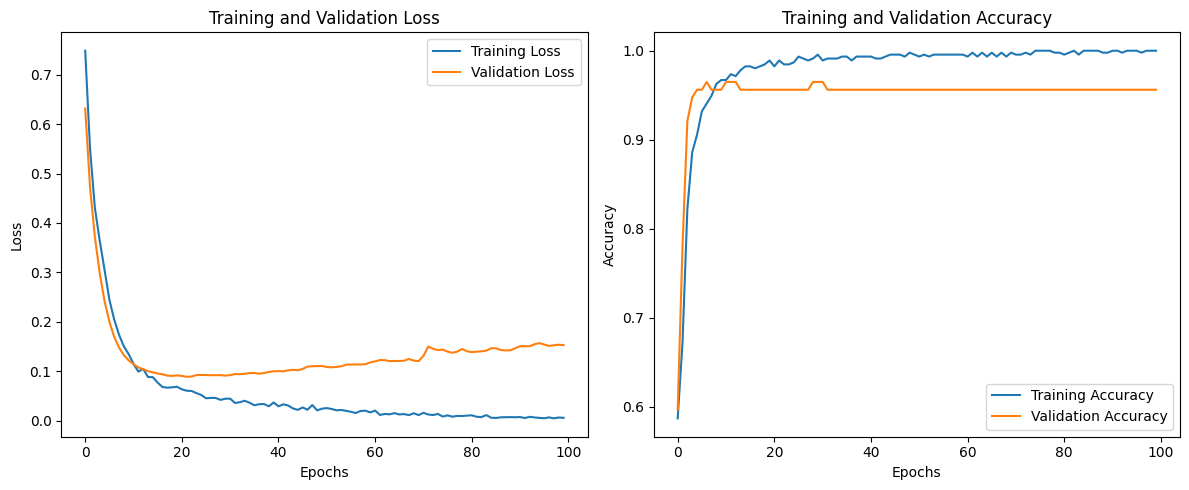

4/4 [==============================] - 0s 6ms/step


In [40]:
# Define Auto-Keras classifier
clf = ak.StructuredDataClassifier(max_trials=10)  # Adjust max_trials as needed


# Perform neural architecture search and capture the training history
history = clf.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Evaluate the model
_, accuracy = clf.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Export the best model
best_model = clf.export_model()
predictions = best_model.predict(X_test)


In [41]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
sclf = ak.StructuredDataClassifier(max_trials=10)
history = sclf.fit(X_train_smote, y_train_smote, epochs=100, validation_data=(X_test, y_test))
_, accuracy = sclf.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Export the best model
best_model = clf.export_model()
predictions = best_model.predict(X_test)

Reloading Tuner from ./structured_data_classifier/tuner0.json
Epoch 1/100
18/18 [==============================] - 2s 35ms/step - loss: 0.6439 - accuracy: 0.6346 - val_loss: 0.5407 - val_accuracy: 0.8246
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.4603 - accuracy: 0.8899 - val_loss: 0.3991 - val_accuracy: 0.9211
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.3593 - accuracy: 0.9003 - val_loss: 0.3078 - val_accuracy: 0.9211
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2726 - accuracy: 0.9318 - val_loss: 0.2440 - val_accuracy: 0.9386
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2271 - accuracy: 0.9336 - val_loss: 0.1998 - val_accuracy: 0.9561
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1929 - accuracy: 0.9406 - val_loss: 0.1697 - val_accuracy: 0.9561
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1523 - accu

In [ ]:
print(best_model.summary())
from tensorflow.keras.utils import plot_model

plot_model(best_model, show_shapes=True, to_file='best_model.png')
